In [2]:
# Baseado em https://thecleverprogrammer.com/2020/08/19/hate-speech-detection-model/
# Base de dados utilizada: https://github.com/amankharwal/Website-data/blob/master/hate%20speech.rar

import pandas as pd
train = pd.read_csv('base/train.csv')
print("Base para treino:"% train.columns, train.shape, len(train))
test = pd.read_csv('base/test.csv')
print("Base para teste:"% test.columns, test.shape, len(test))

Base para treino: (31962, 3) 31962
Base para teste: (17197, 2) 17197


In [3]:
display(train)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
import matplotlib.pyplot as plt

#Número de exemplos positivos e negativos no grupo de treino
fig=plt.figure(figsize=(5,5))
colors=["blue",'red']
pos=train[train['label']==1]
neg=train[train['label']==0]
ck=[pos['label'].count(),neg['label'].count()]
legpie=plt.pie(ck,labels=["Discurso de ódio","Normal"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [5]:
import re

# Limpando texto de emoticons e afins
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

In [6]:
display(train_clean)

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation
...,...,...,...
31957,31958,0,ate isz that youuu
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,sikh temple vandalised in in calgary wso cond...


In [7]:
# Utilizar oversampling para igualar os casos negativos e positivos

from sklearn.utils import resample
train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [8]:
display(train_upsampled)

,id,label,tweet
19492,19493,1,you might be a libtard if libtard sjw libera...
16151,16152,1,is good place to sta learning abt how one pe...
25144,25145,1,allahsoil bernanke bailed out wall street by ...
30902,30903,1,i am just waiting for somebody other than you...
16522,16523,1,why are white people expats when the rest of u...
...,...,...,...
31956,31957,0,off fishing tomorrow carnt wait first time in...
31957,31958,0,ate isz that youuu
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...


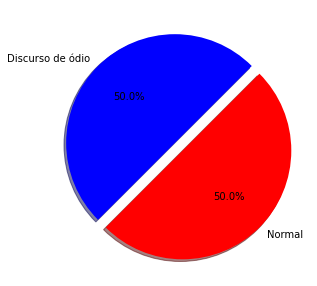

In [9]:
#Número de exemplos positivos e negativos no grupo de treino
fig=plt.figure(figsize=(5,5))
colors=["blue",'red']
pos=train_upsampled[train_upsampled['label']==1]
neg=train_upsampled[train_upsampled['label']==0]
ck=[pos['label'].count(),neg['label'].count()]
legpie=plt.pie(ck,labels=["Discurso de ódio","Normal"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [10]:
# Utilizando a pipeline do Scikit-Learn para o classificador SGD 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', SGDClassifier()),])

In [11]:
# Separando a base de treino em validação e treino

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],random_state = 0)

In [12]:
# Validando modelo

model = pipeline_sgd.fit(X_train, y_train)
y_predict = model.predict(X_test)
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.9696